Retrieve and parse HTML, referring to browser's `Inspect` utility to analyse relevant structure.

In [1]:
import requests
import bs4
import pandas as pd

URL = 'https://www.triathlete.com/training/super-simple-ironman-70-3-triathlon-training-plan/'
RACE_DAY = '9/8/2024'
OUT_FILE = '~/Desktop/sc.csv'

response = requests.get(URL)
soup = bs4.BeautifulSoup(response.text)
tables = soup.find_all('table')
len(tables)

17

Prep data frame and append a new row for each day in each week-table (all tables except the first table).

In [2]:
df = pd.DataFrame({'dow': [], 'wo1': [], 'wo2': [], 'wo3': []})

for i, t in enumerate(tables):
    if i == 0: continue
    # print(f'Week {i}')
    
    trs = t.find_all('tr')
    for tr in trs:
        tds = tr.find_all('td')
        # print(' | '.join(td.text for td in tds))
        df.loc[df.shape[0]] = [td.text for td in tds] + ([''] if i < 16 else [])
        
df.head()

,dow,wo1,wo2,wo3
0,Monday,Rest,,
1,Tuesday,Bike 40 minutes moderate with 4 x 30-second sp...,,
2,Wednesday,"Swim 800 yards total. Main set: 8 x 25 yards, ...",Run 4 miles moderate + 2 x 10-second hill spri...,
3,Thursday,Bike 40 minutes moderate.,,
4,Friday,Swim 800 yards total. Main set: 3 x 100 yards ...,Run 4 miles moderate.,


Given the race day as the end date, back-fill dates until training day 1.

In [3]:
df['start date'] = pd.date_range(end=RACE_DAY, periods=df.shape[0])
df.head()

,dow,wo1,wo2,wo3,start date
0,Monday,Rest,,,2024-05-20
1,Tuesday,Bike 40 minutes moderate with 4 x 30-second sp...,,,2024-05-21
2,Wednesday,"Swim 800 yards total. Main set: 8 x 25 yards, ...",Run 4 miles moderate + 2 x 10-second hill spri...,,2024-05-22
3,Thursday,Bike 40 minutes moderate.,,,2024-05-23
4,Friday,Swim 800 yards total. Main set: 3 x 100 yards ...,Run 4 miles moderate.,,2024-05-24


Merge the multiple `wo` workout columns into just one, in a long format with repeated dates.

Drop rows with empty descriptions, so there aren't any extra empty workouts.

In [4]:
pivot = df.melt(
    id_vars='start date', 
    value_name='description', 
    value_vars=['wo1', 'wo2', 'wo3']
)
pivot_reduced = pivot.drop('variable', axis=1).drop(pivot[pivot['description'] == ''].index)
pivot_reduced.head()

,start date,description
0,2024-05-20,Rest
1,2024-05-21,Bike 40 minutes moderate with 4 x 30-second sp...
2,2024-05-22,"Swim 800 yards total. Main set: 8 x 25 yards, ..."
3,2024-05-23,Bike 40 minutes moderate.
4,2024-05-24,Swim 800 yards total. Main set: 3 x 100 yards ...


Use the first word of each workout description as its event subject/title, and re-sort by date for visual review.

In [5]:
pivot_reduced['subject'] = [' '.join(x[:3]) for x in pivot_reduced['description'].str.split()]
pivot_reduced.sort_values('start date')

,start date,description,subject
0,2024-05-20,Rest,Rest
1,2024-05-21,Bike 40 minutes moderate with 4 x 30-second sp...,Bike 40 minutes
2,2024-05-22,"Swim 800 yards total. Main set: 8 x 25 yards, ...",Swim 800 yards
114,2024-05-22,Run 4 miles moderate + 2 x 10-second hill spri...,Run 4 miles
3,2024-05-23,Bike 40 minutes moderate.,Bike 40 minutes
...,...,...,...
221,2024-09-06,Run 3 miles easy.,Run 3 miles
110,2024-09-07,Swim 10 minutes easy with 4 x 30 seconds at ra...,Swim 10 minutes
222,2024-09-07,Bike 10 minutes with 4 x 30 seconds fast.,Bike 10 minutes
334,2024-09-07,Run 10 minutes with 4 x 20 seconds at 90 perce...,Run 10 minutes


In [6]:
wo_index = ~pivot_reduced['subject'].isin({'Rest', 'RACE DAY'})
pivot_reduced.loc[wo_index, 'workout'] = [x[0] for x in pivot_reduced[wo_index]['description'].str.split()]
pivot_reduced.loc[wo_index, 'length'] = [float(x[1].replace(',', '')) for x in pivot_reduced[wo_index]['description'].str.split()]
pivot_reduced.loc[wo_index, 'metric'] = [x[2] for x in pivot_reduced[wo_index]['description'].str.split()]
pivot_reduced

/var/folders/25/kt506tbj3_bg1b5wxx2km8zr0000gn/T/ipykernel_4790/1300515574.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Bike', 'Swim', 'Bike', 'Swim', 'Bike', 'Run', 'Bike', 'Swim', 'Bike', 'Swim', 'Bike', 'Run', 'Bike', 'Swim', 'Bike', 'Swim', 'Bike', 'Run', 'Bike', 'Swim', 'Bike', 'Swim', 'Bike', 'Run', 'Bike', 'Swim', 'Bike', 'Swim', 'Bike', 'Run', 'Bike', 'Swim', 'Bike', 'Swim', 'Bike', 'Run', 'Bike', 'Swim', 'Bike', 'Swim', 'Bike', 'Run', 'Bike', 'Swim', 'Bike', 'Swim', 'Bike', 'Run', 'Bike', 'Swim', 'Bike', 'Swim', 'Bike', 'Run', 'Bike', 'Swim', 'Bike', 'Swim', 'Bike', 'Run', 'Bike', 'Swim', 'Bike', 'Swim', 'Bike', 'Run', 'Bike', 'Swim', 'Bike', 'Swim', 'Bike', 'Run', 'Bike', 'Swim', 'Bike', 'Swim', 'Bike', 'Run', 'Bike', 'Swim', 'Bike', 'Swim', 'Bike', 'Run', 'Bike', 'Swim', 'Bike', 'Swim', 'Bike', 'Run', 'Bike', 'Swim', 'Bike', 'Swim', 'Swim', 'Run', 'Run', 'Swim', 'Run', 'Run', 'Swim', 'Run', 'Run

,start date,description,subject,workout,length,metric
0,2024-05-20,Rest,Rest,NaN,NaN,NaN
1,2024-05-21,Bike 40 minutes moderate with 4 x 30-second sp...,Bike 40 minutes,Bike,40.0,minutes
2,2024-05-22,"Swim 800 yards total. Main set: 8 x 25 yards, ...",Swim 800 yards,Swim,800.0,yards
3,2024-05-23,Bike 40 minutes moderate.,Bike 40 minutes,Bike,40.0,minutes
4,2024-05-24,Swim 800 yards total. Main set: 3 x 100 yards ...,Swim 800 yards,Swim,800.0,yards
...,...,...,...,...,...,...
216,2024-09-01,"Swim 2,400 yards total. Main set: 600 yards ra...","Swim 2,400 yards",Swim,2400.0,yards
219,2024-09-04,"Run 2 miles easy, 1 mile at 10K race pace, 2 m...",Run 2 miles,Run,2.0,miles
221,2024-09-06,Run 3 miles easy.,Run 3 miles,Run,3.0,miles
222,2024-09-07,Bike 10 minutes with 4 x 30 seconds fast.,Bike 10 minutes,Bike,10.0,minutes


workout  metric 
Bike     miles      Axes(0.125,0.11;0.775x0.77)
         minutes     Axes(0.125,0.2;0.775x0.68)
Run      mile       Axes(0.125,0.11;0.775x0.77)
         miles       Axes(0.125,0.2;0.775x0.68)
         minutes     Axes(0.125,0.2;0.775x0.68)
Swim     minutes     Axes(0.125,0.2;0.775x0.68)
         yards       Axes(0.125,0.2;0.775x0.68)
dtype: object

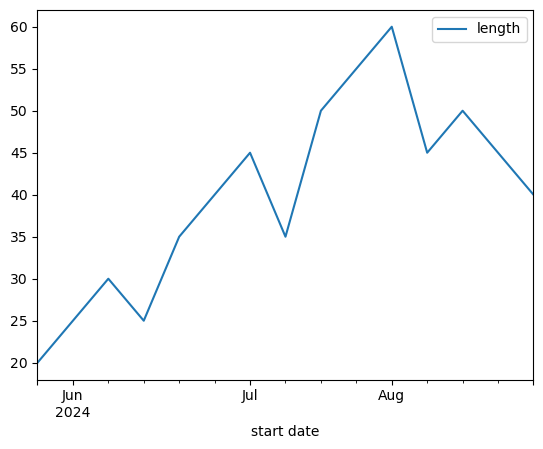

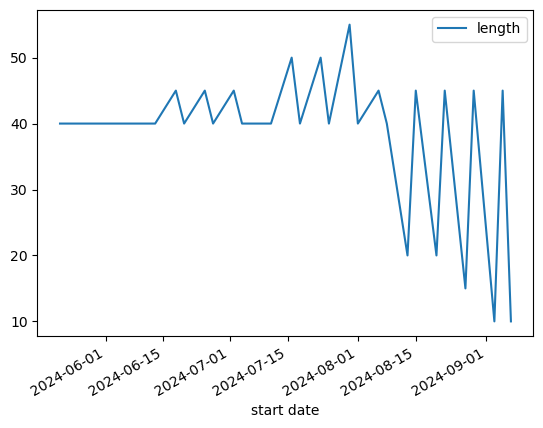

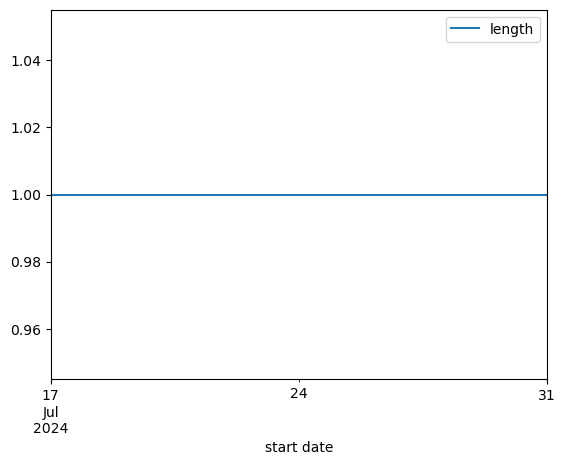

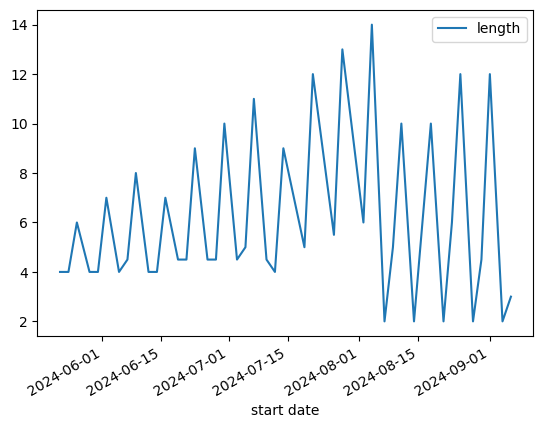

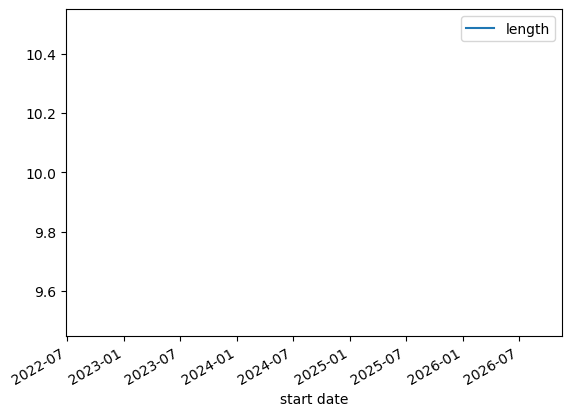

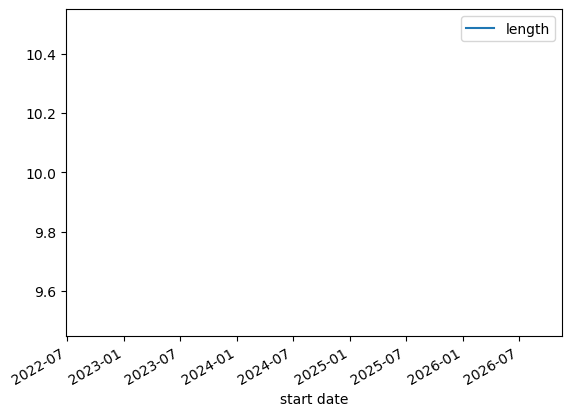

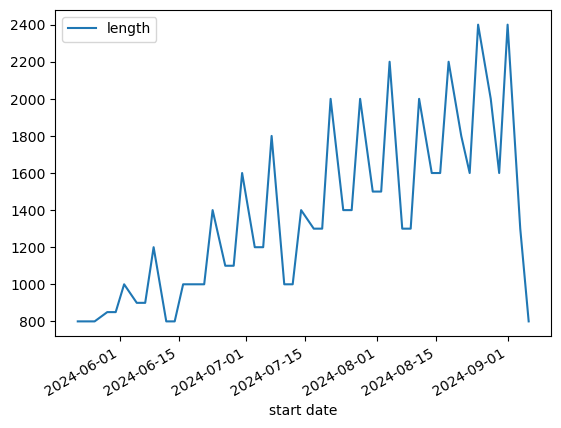

In [7]:
pivot_reduced.groupby(['workout', 'metric']).plot(x='start date', y='length')

Write dataframe to CSV for calendar import.

In [8]:
pivot_reduced.sort_values('start date').to_csv(OUT_FILE, index=False)